Nguyễn Ngọc Sáng (ngocsangvn@gmail.com, [VnCFD](https://vncfdgroup.wordpress.com/)), Zhukovsky 12/2018

*Thực hành CFD với Python!*

# Bài 7. Phương trình Burgers hai chiều

Phương trình Burgers hai chiều có dạng:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \; \left(\frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}\right)$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = \nu \; \left(\frac{\partial ^2 v}{\partial x^2} + \frac{\partial ^2 v}{\partial y^2}\right)$$

Để tìm nghiệm ta sử dụng sơ đồ sai phân tiến cho thời gian và sai phân trung tâm cho không gian:

$$
\begin{split}
& \frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} + u_{i,j}^n \frac{u_{i+1,j}^n-u_{i-1,j}^n}{2\Delta x} + v_{i,j}^n \frac{u_{i,j+1}^n - u_{i,j-1}^n}{2\Delta y} = \\
& \qquad \nu \left( \frac{u_{i+1,j}^n - 2u_{i,j}^n+u_{i-1,j}^n}{\Delta x^2} + \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2} \right)
\end{split}
$$
$$
\begin{split}
& \frac{v_{i,j}^{n+1} - v_{i,j}^n}{\Delta t} + u_{i,j}^n \frac{v_{i+1,j}^n-v_{i-1,j}^n}{2\Delta x} + v_{i,j}^n \frac{v_{i,j+1}^n - v_{i,j-1}^n}{\Delta y} = \\
& \qquad \nu \left( \frac{v_{i+1,j}^n - 2v_{i,j}^n+v_{i-1,j}^n}{\Delta x^2} + \frac{v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j-1}^n}{\Delta y^2} \right)
\end{split}
$$

Ta có công thức xác định nghiệm:

$$
\begin{split}
u_{i,j}^{n+1} = & u_{i,j}^n - \frac{\Delta t}{2\Delta x} u_{i,j}^n (u_{i+1,j}^n - u_{i-1,j}^n)  - \frac{\Delta t}{2\Delta y} v_{i,j}^n (u_{i,j+1}^n - u_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n-2u_{i,j}^n+u_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j+1}^n)
\end{split}
$$

$$
\begin{split}
v_{i,j}^{n+1} = & v_{i,j}^n - \frac{\Delta t}{2\Delta x} u_{i,j}^n (v_{i+1,j}^n - v_{i-1,j}^n) - \frac{\Delta t}{2\Delta y} v_{i,j}^n (v_{i,j+1}^n - v_{i,j-1}^n) \\
&+ \frac{\nu \Delta t}{\Delta x^2}(v_{i+1,j}^n-2v_{i,j}^n+v_{i-1,j}^n) + \frac{\nu \Delta t}{\Delta y^2} (v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j+1}^n)
\end{split}
$$

**Bài toán**

Trên miền hình vuông [0,4]x[0,4] điều kiện ban đầu u(x, y, 0) = 1, ngoại trừ vùng [1,2]x[1,2] u(x, y, 0) = 2. Xét trong khoảng thời gian dao động còn chưa lan truyền tới biên.

**Coding**

Code này có phần giống bài 4 - phương trình Laplace khi sử dụng mảng hai chiều. 

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
from mpl_toolkits.mplot3d import Axes3D #khai báo thư viện để vẽ đồ thị 3D

#chia lưới đều 
nx = 41
ny = 41
x, dx = np.linspace(0, 4, nx, retstep=True) #retstep - return step spacing
y, dy = np.linspace(0, 4, ny, retstep=True)

#điều kiện ban đầu
u0 = np.ones((ny, nx))
v0 = np.ones((ny, nx))

u0[int(1./dy):int(2./dy), int(1./dx):int(2./dx)] = 2
v0[int(1./dy):int(2./dy), int(1./dx):int(2./dx)] = 2

In [124]:
#Tìm nghiệm

#mảng chứa nghiệm tại bước n
un = np.empty((ny, nx))
vn = np.empty((ny, nx))

#mảng chứa nghiệm tại bước n+1
u = np.empty((ny, nx))
v = np.empty((ny, nx))

#hàm solver:
#Để đảm bảo tính ổn định của sơ đồ ta lấy giá trị r = nu*dt/(dx*dy) rất nhỏ
def solver(r, nu, nt):
    dt = r/nu*dx*dy
    #lấy giá trị nghiệm ban đầu 
    u = u0.copy()
    v = v0.copy()
    for n in range(nt):
        #lưu nghiệm ở bước n
        un = u.copy()
        vn = v.copy()
        #tính nghiệm ở bước n+1
        u[1:-1, 1:-1] = un[1:-1, 1:-1] -\
                        dt/(2*dx)*un[1:-1, 1:-1]*(un[1:-1, 2:] - un[1:-1, 0:-2])-\
                        dt/(2*dy)*vn[1:-1, 1:-1]*(un[2:, 1:-1] - un[0:-2, 1:-1])+\
                        nu*dt/(dx**2)*(un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2])+\
                        nu*dt/(dy**2)*(un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1])
        v[1:-1, 1:-1] = vn[1:-1, 1:-1] -\
                        dt/(2*dx)*un[1:-1, 1:-1]*(vn[1:-1, 2:] - vn[1:-1, 0:-2])-\
                        dt/(2*dy)*vn[1:-1, 1:-1]*(vn[2:, 1:-1] - vn[0:-2, 1:-1])+\
                        nu*dt/(dx**2)*(vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, 0:-2])+\
                        nu*dt/(dy**2)*(vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[0:-2, 1:-1])
    return u, v

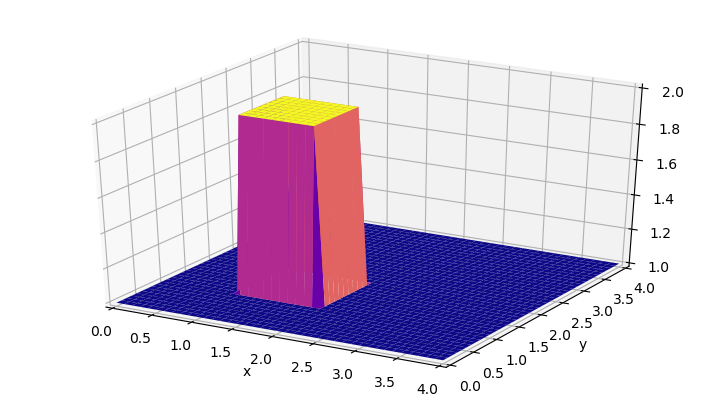

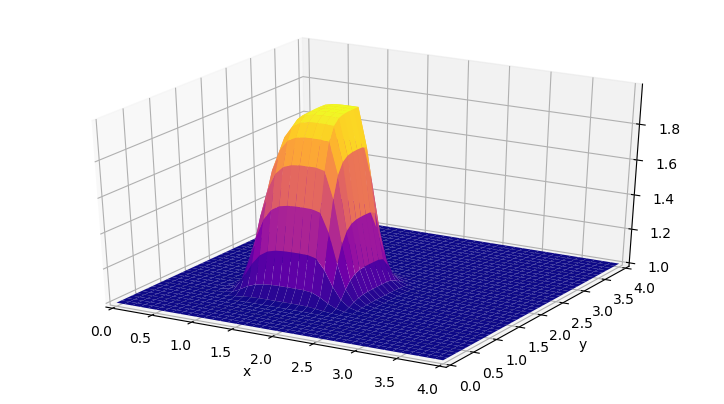

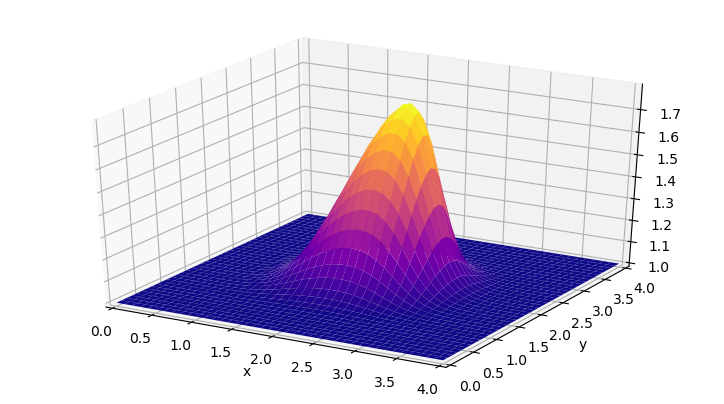

In [125]:
r = 0.01
nu = 0.1
u1, v1 = solver(r, nu, 100)
u2, v2 = solver(r, nu, 500)

def plot(u):
    fig = plt.figure(figsize=(9, 5), dpi=100) #Top level container for all plot elements.
    ax = fig.gca(projection='3d') #Get the current Axes
    X, Y = np.meshgrid(x, y) # tạo lưới điểm (X, Y)
    surf = ax.plot_surface(X, Y, u, cmap=cm.plasma)
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()    

plot(u0)
plot(u1)
plot(u2)

Kết quả cho ta thấy đỉnh sóng chuyển động nhanh hơn, có xu hướng xuất hiện đứt gãy, tuy nhiên thành phần nhớt sẽ kiềm chế điều này.

### [Bài 8. Hệ phương trình Navier - Stokes cho chất lỏng không nén được. Phương pháp MAC](Bai_8.ipynb)